<a href="https://colab.research.google.com/github/olamiketech/zero-to-mastery-ml/blob/master/Practical4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ITNPAI1 Practical 4 - YOLOv8

YOLOv8 is the latest version of the YOLO series of models, developed by Ultralytics (https://www.ultralytics.com). It is a state-of-the-art model used for object detection, image classification, and instance segmentation tasks.

Many applications, such as autonomous driving, demand both precision and rapid inference. Therefore, selecting an Object Detector that balances speed and accuracy is crucial.

In [ ]:
#Can be commented out after first run.
!pip install -U ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 kB 10.6 MB/s eta 0:00:00


# Detection with YOLOv8


In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
import random

Once we have imported the libraries we need, we download the default YOLOv8 model weights. There are 5 different versions for us to choose from. In today's practical, we will use yolov8n ('n' for nano). Feel free to try yolov8s (small), yolov8m (medium), yolov8l (large) or yolov8x (extra large), in your spare time.

In [ ]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 121MB/s]


Let's try to use the default weights on an the Turing image that we used in the previous practical.

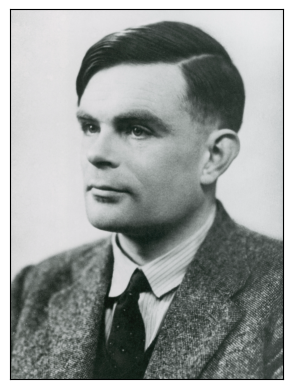

In [ ]:
img = cv2.imread('/content/drive/MyDrive/images/turing.jpg', cv2.IMREAD_COLOR)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
results = model(img)  # predict on an image


0: 640x480 1 person, 1 tie, 189.0ms
Speed: 17.1ms preprocess, 189.0ms inference, 986.4ms postprocess per image at shape (1, 3, 640, 480)


Our model has detected one person and one tie in the image. Let's see if we can localise them.

In [ ]:
detected_img = img.copy()
'''
Results is a list, as the model can take in a list of images and return a list of results.
As we are just working with one image, we can loop over each of the bounding boxes returned by our model.
We can then manually draw each bounding box on our image.
'''
for box in results[0].boxes:
  class_id = results[0].names[box.cls[0].item()] # Get class name
  cords = box.xyxy[0].tolist() # Get coordinates
  cords = [round(x) for x in cords]
  conf = round(box.conf[0].item(), 2) # Get confidence score to two decimal places
  detected_img = cv2.rectangle(detected_img, (cords[0], cords[1]), (cords[2], cords[3]), (255, 0, 0), 8) #Draw bounding box.
  cv2.putText(detected_img, (class_id + " " + str(conf)), (cords[0], cords[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 12) #Add class text, with confidence value.

In [ ]:
plt.imshow(detected_img)
plt.xticks([]), plt.yticks([])
plt.show()

# Segmentation with YOLOv8
To perform segmentation, we first load in the nano, segmentation version of YOLOv8.

In [ ]:
model = YOLO("yolov8n-seg.pt")
results = model.predict(img)

100%|██████████| 6.73M/6.73M [00:00<00:00, 123MB/s]



0: 640x480 1 person, 1 tie, 35.4ms
Speed: 3.8ms preprocess, 35.4ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 480)


We then load the class names, and generate random colours to be used in our masks.

In [ ]:
yolo_classes = list(model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]
colours = [random.choices(range(256), k=3) for _ in classes_ids]

In [ ]:
'''
This function will take an image, the model we have loaded, and the random colours we have just generated.
It then draws transparent masks on the image, showing the segmented regions.
The segmented image is then returned.
'''
def segment_image(image, model, colours):
  results = model.predict(image)
  segmented_img = image.copy()
  for mask, box in zip(results[0].masks.xy, results[0].boxes):
    points = np.int32([mask])
    color_number = classes_ids.index(int(box.cls[0]))
    cv2.fillPoly(segmented_img, points, colours[color_number])
    segmented_img = cv2.addWeighted(segmented_img, 0.5, image, 1 - 0.5, 0)
  return segmented_img


0: 640x480 1 person, 1 tie, 11.3ms
Speed: 8.0ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


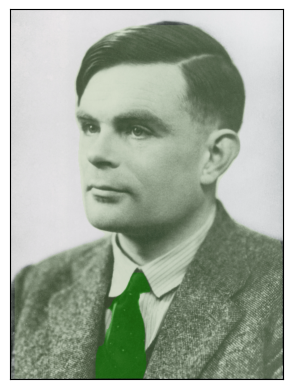

In [ ]:
seg = segment_image(img, model, colours)
plt.imshow(seg)
plt.xticks([]), plt.yticks([])
plt.show()

Here is another example.


0: 640x480 2 cats, 21.8ms
Speed: 3.7ms preprocess, 21.8ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 480)


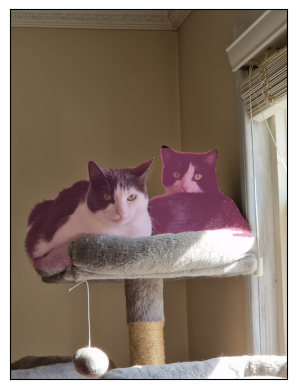

In [ ]:
cats = cv2.imread('/content/drive/MyDrive/images/cats.jpg', cv2.IMREAD_UNCHANGED)
cats = cv2.cvtColor(cats, cv2.COLOR_BGR2RGB)
seg = segment_image(cats, model, colours)
plt.imshow(seg)
plt.xticks([]), plt.yticks([])
plt.show()

### Pose Estimation

Lastly, we will apply a task called "pose estimation" to a video, again using YOLOv8. The output video will be saved in a directory named "runs", so please pay attention to the output.

In [ ]:
model = YOLO("yolov8n-pose.pt")

100%|██████████| 6.51M/6.51M [00:00<00:00, 123MB/s]


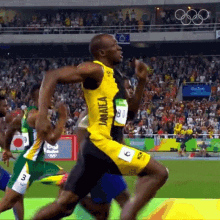

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/images/bolt.gif',embed=True)

In [ ]:
model(source = '/content/drive/MyDrive/images/bolt.gif', conf= 0.3, save = True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/25) /content/drive/MyDrive/images/bolt.gif: 640x640 1 person, 11.0ms
video 1/1 (2/25) /content/drive/MyDrive/images/bolt.gif: 640x640 1 person, 9.7ms
video 1/1 (3/25) /content/drive/MyDrive/images/bolt.gif: 640x640 1 person, 9.2ms
video 1/1 (4/25) /content/drive/MyDrive/images/bolt.gif: 640x640 2 persons, 8.3ms
video 1/1 (5/25) /content/drive/MyDrive/images/bolt.gif: 640x640 2 persons, 8.3ms
video 1/1 (6/25) /content/drive/MyDrive/images/b

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'person'}
 obb: None
 orig_img: array([[[106,  97,  98],
         [106,  97,  98],
         [106,  97,  98],
         ...,
         [122, 114, 112],
         [116, 105, 107],
         [116, 105, 107]],
 
        [[115, 104, 101],
         [115, 104, 101],
         [115, 104, 101],
         ...,
         [129, 104, 101],
         [115, 104, 101],
         [115, 104, 101]],
 
        [[115, 104, 101],
         [115, 104, 101],
         [115, 104, 101],
         ...,
         [ 82,  70,  65],
         [ 76,  59,  59],
         [ 71,  56,  58]],
 
        ...,
 
        [[ 96, 231, 150],
         [ 96, 231, 150],
         [ 96, 231, 150],
         ...,
         [ 74, 251, 238],
         [ 74, 251, 238],
         [ 74, 251, 238]],
 
        [[ 96, 231, 150],
         [ 81, 236, 152],
         [ 96, 231,

## Now navigate to, and download the video you have created to view the predicted output. (See the "save_dir" attribute in the output above.)

#Summary and Bonus Tasks
You can now use the YOLOv8 model to perform classification, detection, segmentation, and pose estimation.

We have just scratched the surface. Once you feel comfortable with the code above, try some of the following:


*   Use your own images and videos.
*   Use the larger versions of YOLOv8. Do you notice a significant difference in runtime/performance?
*   Apply classification, detection, and segmentation to videos, just like we did with pose estimation.
*   Training and validating your own YOLOv8 model. Ultralytics facilitate a variety of datasets (https://docs.ultralytics.com/datasets/?h=datase) for you to train and validate on. (https://docs.ultralytics.com/modes/train/#key-features-of-train-mode)
*   If you are comfortable using jupyter on your own device and have access to a webcam, try to use YOLOv8 on live video (https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html).



